<center>
<h1 style="font-size: 36px;">NBA Line Up Analysis</h1>
</center>

[GitHub Repo](https://github.com/BrianMillerS/TOOL1_FINAL_PROJECT)  
Data Science Tools 1 Final Project  
Group Members: Brian Hanson, Brian Miller  
March 9th, 2023

## Dataset and Motivation: (1 point)
****(1pt) How/why the dataset was collected and a description of the metadata of your dataset?****  

We will be working in the field of NBA sports analytics. For the NBA, there is no shortage of data available. To answer our research questions we pulled data from two different sources:  
 - Player statistics data (age, salary, height, weight, as well as performance summary statistics from prior seasons)  
 - NBA game play-by-play data (which has in-game event events recorded down to the second)  
  
We obtained the player statistics from [www.basketball-reference.com](https://www.basketball-reference.com/). Here is an example, [Kevin Durant (id = duranke01)](https://www.basketball-reference.com/players/d/duranke01.html)  
  
We obtained the play-by-play data from a [Kaggle dataset of play-by-play data for each season](https://www.kaggle.com/datasets/schmadam97/nba-playbyplay-data-20182019?resource=download), which was obtained in turn by scraping basketball-reference. 
  
- For the purposes of this analysis we only focused on the 2016 NBA season. Including more years will be useful. But for simplicity sake we just stuck to a single year.
- For a more detailed description of howe exactly we scraped the data, and the labor intensive intricacies of that process, please see the Quality of Cleaning section below.
  



## Research Question: (2 points)
***(2pts) What real-world problem are you trying to solve? What are the input and output of your analysis?***  
  
Main Question:  
For the 2016 NBA season, what are the specific NBA player lineups (set of 5 players) that perform the best?  
  
To answer this question, after observing and cleaning the data, the main performance metric that will be assessing each lineup by is
**PtsDiff_perPos**. For the entire 2016 season, this is the total number of points scored, minus the total number of points allowed, divided by the total number of possessions. The inputs for this is a table of all of the unique lineups, with their metrics. The output is the distribution of **PtsDiff_perPos** visualized, and the top 5% of performing lineups displayed.
  
Secondary Question:  
Are there player metrics (age, salary, height, weight) that correlate with a high performing lineup?
  
To answer this question we will perform a linear model (GLM specifically) to help us determine which metrics were significantly associated with **PtsDiff_perPos**. The inputs for this is a table of all of the unique lineups, with their metrics. The output is a summary of the results from the linear model.


## Literature Review: (2 points)  
***(2pts) What other work has been done in this area, and how is your work novel compared to others?***  
  
There has been lots of sports analytics done with this data. But, this is the first analysis that I have seen that breaks down 
5-player lineups with the various summary statistics that we use. Most of the lineup predictions are usually centered around 
what player is popular in the NBA culture/scene at that moment, and do not take an analytical approach [example: Sports Illustrated best linup prediction](https://www.si.com/nba/2020/05/25/best-nba-all-time-starting-lineup)  
  
I think one aspect what separates us apart from the other analyses that I have seen is our use off play by play data to account for the total
number of posessions that the given lineup had. Without normalizing by this metric it's more difficult to detmine which lineup was supporior,
given that the number of attempts for shots, blocks, and other performance metrics.

## Quality of Cleaning: (6points)  
***(2pts) Data cleaning and type conversion activity.  Please share anything unusual you faced during this activity.***  
  

The datasets we downloaded from kaggle contains a row for every play from every game for a particular NBA season. We chose to focus on the 2015-2016 season and encountered a number of challenges in both data cleaning and feature engineering.
The dataset, as initially downloaded, contains columns for describing  events (eg, ReboundType, ShotDistance, FreeThrowNum) and columns for identifying players who are credited with each event (eg, Rebounder, Shooter, TurnoverCauser). Values in player-identification columns are strings containing a unique (usually 9 character) player-id from basketball-reference.com with the format '{BBR_id} - {First Name} {Last Name}'. The first step in data cleaning was to strip identification values down to only the BBR_id string.
The large majority of rows in this dataset are NaN. This is because when a row logs one single event, all of the columns associated with other events will have no values. Some of these null values are stored as np.nan objects, others as strings with the value 'NULL', which need to be changed to np.nan values.
Later feature engineering requires determining whether the home or away team is associated with a given event. There is a discrepancy among certain FoulTypes, so for 'loose ball,' 'offensive,' and 'technical' fouls the home/away team tag was switched so that the event is always listed for the team that was fouled, rather than committed the foul.
Some rows in the dataset are incorrectly listed out of the order in which they actually occured, so in the add_timestamp function the events of each individual game are sorted by quarter (ascending) and seconds remaining (descending) before reindexing.
  
***(2pts) New feature/attribute creation and data summary statistics and interpretation.***  
  
This project involved extensive feature engineering with 4 main goals and numerous algorithms required to engineer them:   
  
1) Determine which game events conclude a possession, and thus quantify possessions which occur throughout the game and their results. In basketball a possession is the duration that a given team is on offense and a possession ends when the defending team gains the ball and begins to attempt to score. A possession can conclude in 5 ways: a made shot (without a co-temporal shooting foul), a defensive rebound following a missed shot, a turnover, a made free-throw which is the last in a set of non-technical free-throws awarded to the offensive team, the end of a quarter, and a jump-ball.
    - We used boolean indexing within individual games to identify all rows which correspond to each of the conditions involved with the end of a possession. 
    - We created new column identifying events which conclude a home possession and events which conclude an away possession, as well as columns to track the cumulative sum of home and away possessions.  
  
2) Determine which 5 players are on the court for both home and away teams for each game event.
    - The first step is to run a function to identify which players from both teams participated in each quarter by recording all player_ids within each quarter. Some players have their team mislabeled (such as an away player identified in the 'JumpballHomePlayer' column), so the scraped player information in feature engineering section 3 is used to identify whether each player belonged to the home team or away team during the season in which the game occured. Then in the add_lineup_cols function, a column is assigned to each player with a boolean value of whether they are on the court or not for that event. These player columns are initialized with only False values, then, on a player-by-player and quarter-by-quarter basis True values are filled for the indicies between when that player substituted into a game and later substituted out of the game, with logical methods accounting for players that started a quarter in the game, ended a quarter in the game, or played the entire quarter without substituting out. It is necessary to parse lineups quarter-by-quarter because the dataset used does not identify substitutions which take place during the break between quarters. The sum of the boolean values for home and away players is then checked to ensure it equals 5 for both teams for all game events. There are some errors in the substitution data in the original dataset, so for each season there are some games in which there are events with home or away players not equal to 5. In some instances, a player participates in an entire quarter without appearing in any player-identification columns. In these cases one team will have 4 players in its lineup for the entire quarter (most often in shorted 5-minute overtime "quarters"). There is a function that identifies these particular cases and scrapes the boxscore for the game in question from basketball-reference.com. If there is one player with a discrepancy in minutes played between the scraped boxscore and the time elapsed in the events they participating in our datafrom, the function will compare the minutes discrepancy. In the case that one player's minutes discrepancy matches the length of the quarter with a 4-player lineup, then that player's column will be filled with True values for the entire quarter. Any lineup discrepancies which remain after this step result in the entire game in question being removed from the dataset. The home and away lineups are retained in a column with a string of 5 player ids, sorted from shortest to tallest, separated by commas. This allows the lineup data to be stored in a hashable format than can be operated on with string methods.  
  
3) Scrape and store biographical attributes and past-season performance statistics for every player participating in a game event.
    - Player ids identified from the play-by-play dataframe are then passed to a function which scrapes player information from basketball-reference.com, which has a player profile for every individual to participate in any NBA game. Each player's page has a header with biographical information (including birthdate, height, weight) and statistics from each of their seasons in the NBA, as well as information about their yearly salary (where available). The scraping function uses beautifulsoup to collect information from the webpage's header and pandas to read statistical tables into dataframes. The dataframes obtained for each player are then stored in a python dictionary and individually saved as csvs within the directory 'Players' and a subdirectory named for the player's unique id.  
  
4) Determine the aggregate performance of 5-player lineups along with the aggregate attributes of those lineups.
    - Finally we use the pandas groupby function to aggregate the season-long events-possessions-lineups data into one of two versions: a dataframe aggregated for each lineup against all of their opponents, and a dataframe aggregated by each matchup of two lineups against eachother. The seconds played, possessions played, points scored, and points allowed are summed for each lineup. At this point a separate function aggregates a given statistic (eg, height, weight, age (as of January 1 in the season in question)) about each player in each lineup into a list or summary statistic such as mean, range, or standard deviation. These aggregate attributes of lineups can then be compared to the performance of lineups to identify patterns and ideally inform decision-making about how arbitrary lineups might be expected to perform.  
  
***(2pts) What did you do about missing values and why? Handling missing values properly is very important.***  
  
Incorrect values, inconsistently entered values, and incorrectly ordered values are more of an issue in this dataset than missing values. We handled these as discussed above in data cleaning.


## Visualization (8 points, 2 each)  
The code below this last markdown cell has all of the analysis and visualizations.
  
***(2pts) Data visualization activity (box plot, bar plot, violin plot, and pairplot to see relationships and distribution, etc.).***  
***(2pts) Describe anything you find in the data after each visualization.***  
***(2pts) What data visualization helped you understand about data distribution.***  
***(2pts) What you did about possible outlier as per data distribution visualization. (Did you confirm with your client whether it is actually an outlier or put a disclosure statement in your notebook if you decided to remove it?)***  

Overview of Visualization And Analysis Performed:  
 - Summary statistics
 - Visualize distributions
 - Outlier handling
 - Linear model, to explore variables that influence the performance of a given lineup
 - Visualize individual player contributions to lineups

In [1]:
## Dependencies ##

# load custom functions from our support py files
from play_by_play import load_seasons, get_lineup_feature, get_lineup_results, melt_df

# load general dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats


In [2]:
## LOAD DATA, The whole 2016 NBA data play-by-play ##

# df_2016 = load_seasons(seasons=[16], lineups=True, possessions=True, drop_lineup_miscount_games=True)[0]

# df_2016.to_csv('df_2016.csv', index=False)

df_2016 = pd.read_csv('df_2016.csv')


In [3]:
# getting a sense of what the NBA 2016 play by play raw data looks like
print(df_2016.info())
df_2016.head()

# Please note that the two variables AwayLineup and HomeLineup have already been added to our dataset. 
#
# Obtaining the information about who exactly was on the court at each second of each game was labor intensive 
# as this information was not proved with the data. For each game, for each play (row in the play-by-play data),
# if a player was ever mentioned, look them up on basketball-reference, get their team information, and add them
# the AwayLineup or HomeLineup respectively. See our function load_seasons() for more details.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600694 entries, 0 to 600693
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   URL                     600694 non-null  object 
 1   GameType                600694 non-null  object 
 2   Location                600694 non-null  object 
 3   Date                    600694 non-null  object 
 4   Season                  600694 non-null  object 
 5   WinningTeam             600694 non-null  object 
 6   Quarter                 600694 non-null  int64  
 7   SecLeft                 600694 non-null  int64  
 8   Timestamp               600694 non-null  int64  
 9   SecElapsed              600692 non-null  float64
 10  AwayTeam                600694 non-null  object 
 11  AwayPlay                304240 non-null  object 
 12  AwayPossEnd             600694 non-null  bool   
 13  AwayPoss                600694 non-null  int64  
 14  AwayPts             

,URL,GameType,Location,Date,Season,WinningTeam,Quarter,SecLeft,Timestamp,SecElapsed,...,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,AwayLineup,HomeLineup
0,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,2015-10-27 20:00:00,2015-16,DET,1,720,1,0.0,...,NaN,NaN,NaN,NaN,NaN,drumman01,horfoal01,ilyaser01,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01","teaguje01,bazemke01,korveky01,millspa01,horfoal01"
1,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,2015-10-27 20:00:00,2015-16,DET,1,701,2,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01","teaguje01,bazemke01,korveky01,millspa01,horfoal01"
2,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,2015-10-27 20:00:00,2015-16,DET,1,699,3,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01","teaguje01,bazemke01,korveky01,millspa01,horfoal01"
3,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,2015-10-27 20:00:00,2015-16,DET,1,697,4,2.0,...,NaN,bazemke01,bad pass,NaN,NaN,NaN,NaN,NaN,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01","teaguje01,bazemke01,korveky01,millspa01,horfoal01"
4,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,2015-10-27 20:00:00,2015-16,DET,1,681,5,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01","teaguje01,bazemke01,korveky01,millspa01,horfoal01"


In [4]:
# for all of 2016, get all of the unique 5-player lineups from either team
df_2016_lineups_featues_mean = get_lineup_results(df_2016, return_lineup_matchups=False)

# for each of the player attributes that we are interested in, get that player's data from nba-reference.com
for stat_i in ['Height_cm', 'Mass_kg', 'age', 'salary']:
    df_2016_lineups_featues_mean = get_lineup_feature(df_2016_lineups_featues_mean, 
                                                      table_name='info', 
                                                      col_name= stat_i, seasons_ago=1, 
                                                      agg='mean', 
                                                      delta_AwayHome=False)
    
# please note that get_lineup_feature() is a function that adds columns (one for each player attribute e.g. 'age') to an
# existing dataframe. This is why iy is called on df_2016_lineups_featues_mean directly. There are many options for this
# function for which aggragate to return. Here I just want to get the average so agg = 'mean'.

# OPTIONS for get_lineup_feature() params:
# col_name ('Height_cm', 'Mass_kg', 'age', 'salary')
# agg ('list', 'mean', 'median', 'min', 'max', 'range', 'std')
    
# add some additional custom summary statistics
df_2016_lineups_featues_mean["PtsDiff"] = df_2016_lineups_featues_mean["PtsScored"] - df_2016_lineups_featues_mean["PtsAllowed"]
df_2016_lineups_featues_mean["PtsDiff_perPos"] = df_2016_lineups_featues_mean["PtsDiff"] / df_2016_lineups_featues_mean["TotalPossessions"]


# please note that all of the variables below, in df_2016_lineups_featues_mean dataframe, 
# were engineered by us to summarize the stats for an entire season for a given set of 5 players:

# *VARIABLE*          *DESCRIPTION*
# Season              2016 
# Lineup              unique set of 5 players
# SecElapsed          total number of seconds for the whole season that the lineup played
# Home                True/False if True, all stats are only for home games
# OffPoss             offensive possessions
# DefPoss             defensive posessions
# PtsScored           points scored
# PtsAllowed          points allowed
# OffPPP              avg offensive points per possession
# DefPPP              avg defensive points per possession
# TotalPossessions    total number of posessions that the lineup had over the season
# SecElapsedCumDist   cumlative distribution of time
# TotPossCumDist      cumlative distribution of posessions
# LineupMean_cm       cm
# LineupMean_kg       kg
# LineupMean_age      years
# LineupMean_salary   $
# PtsDiff             points scored - points allowed
# PtsDiff_perPos      (points scored - points allowed) / total number of posessions

# the output below is internal to the function get_lineup_feature() and was used by us to help debug where web scraping errors occured 
# while each player was looked up on nba-reference.com

Loading vaughra01... Loading fraziti01... Loading gasolma01... Loading nichoan01... Loading artesro01... Loading ellinwa01... Loading zelleco01... Loading barneha02... Loading smithja02... Loading asikom01... Loading walkeke02... Loading hollajo02... Loading okafoja01... Loading eddieja01... Loading willima02... Loading novakst01... Loading lillada01... Loading brownan02... Loading dragigo01... Loading foyera01... Loading obriejj01... Loading porteot01... Loading aminual01... Loading hasleud01... Loading wilcocj01... Loading cartemi01... Loading zellety01... Loading bogdabo02... Loading stokeja01... Loading nealga01... Loading hensojo01... Loading griffbl01... Loading roberan03... Loading smithis01... Loading bargnan01... Loading bealbr01... Loading anderju01... Loading conlemi01... Loading hoodro01... Loading caulewi01... Loading noelne01... Loading ennisty01... Loading barnema02... Loading anderch01... Loading crowdja01... Loading blakest01... Loading greener01... Loading hawessp01..

In [5]:
# show the lineup data
print(df_2016_lineups_featues_mean.info())
df_2016_lineups_featues_mean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18082 entries, 0 to 18081
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Season             18082 non-null  object 
 1   Lineup             18082 non-null  object 
 2   SecElapsed         18082 non-null  float64
 3   Home               18082 non-null  bool   
 4   OffPoss            18082 non-null  int64  
 5   DefPoss            18082 non-null  int64  
 6   PtsScored          18082 non-null  int64  
 7   PtsAllowed         18082 non-null  int64  
 8   OffPPP             17568 non-null  float64
 9   DefPPP             17635 non-null  float64
 10  TotalPossessions   18082 non-null  int64  
 11  SecElapsedCumDist  18082 non-null  float64
 12  TotPossCumDist     18082 non-null  float64
 13  LineupMean_cm      18082 non-null  float64
 14  LineupMean_kg      18082 non-null  float64
 15  LineupMean_age     18082 non-null  float64
 16  LineupMean_salary  180

,Season,Lineup,SecElapsed,Home,OffPoss,DefPoss,PtsScored,PtsAllowed,OffPPP,DefPPP,TotalPossessions,SecElapsedCumDist,TotPossCumDist,LineupMean_cm,LineupMean_kg,LineupMean_age,LineupMean_salary,PtsDiff,PtsDiff_perPos
0,2015-16,"teaguje01,bazemke01,korveky01,millspa01,horfoal01",32029.0,False,1088,1085,1154,1137,1.060662,1.047926,2173,0.004201,0.004255,198.2,99.2,29.864,9349295.8,17,0.007823
1,2015-16,"westbru01,roberan03,ibakase01,duranke01,adamsst01",33182.0,True,1079,1082,1276,1052,1.182576,0.972274,2161,0.008552,0.008487,203.6,103.8,25.444,10548536.0,224,0.103656
2,2015-16,"westbru01,roberan03,ibakase01,duranke01,adamsst01",32342.0,False,1046,1050,1185,1092,1.132887,1.040000,2096,0.012794,0.012592,203.6,103.8,25.444,10548536.0,93,0.044370
3,2015-16,"teaguje01,bazemke01,korveky01,millspa01,horfoal01",28959.0,True,983,966,1032,951,1.049847,0.984472,1949,0.016592,0.016408,198.2,99.2,29.864,9349295.8,81,0.041560
4,2015-16,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01",27889.0,False,902,890,930,937,1.031042,1.052809,1792,0.020249,0.019918,200.2,103.2,25.186,6612770.2,-7,-0.003906


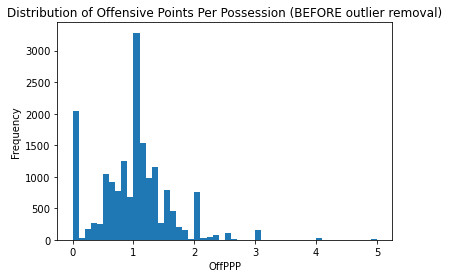

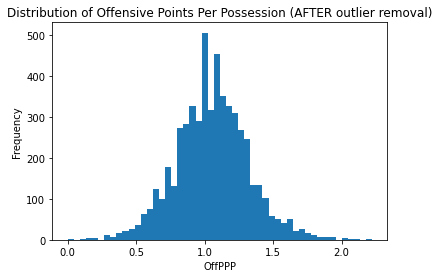

In [6]:
## OUTLIER HANDLING ##

# The metric of points scored per possession (OffPPP) is important because we use it to determine our performance metric.
# As you can see from the distribution below we have some outliers to handle, specifically OffPPP >3 and = 0. Both of these
# are indeed possible values:
# 0 : the lineup never scored any points (probably because those 5 only played for a few seconds)
# 4,5 : a shooting foul on a 2pt and 3pt (where the shooter makes the shot and both free throws)
# Thus both of these outlier cases are possible, but may not be needed for our analysis. 
# Since lineups with zero points are not useful, and the frequency of a 4 and 5 pt outcome is so low.

# OffPP before Outlier removal
plt.hist(df_2016_lineups_featues_mean['OffPPP'].replace([np.inf, -np.inf], np.nan), bins=50)
plt.title('Distribution of Offensive Points Per Possession (BEFORE outlier removal)')
plt.xlabel('OffPPP')
plt.ylabel('Frequency')
plt.show()

# Regardless though, we should perform some quick and logical bounding of our data.

# We will drop lineups that had less than 20 possessions
# this is arbitrary, but with an average possession time of 15s, it's reasonable to only look at 
# 5-player lineups that have enough data, and 10 possession or 300s of playtime is a logical start,
# but this could be optimized in future iterations of this analysis to numerically determine a cuttoff
df_2016_lineups_featues_mean = df_2016_lineups_featues_mean[df_2016_lineups_featues_mean['TotalPossessions'] > 20]

# OffPP after Outlier removal
plt.hist(df_2016_lineups_featues_mean['OffPPP'], bins=50)
plt.title('Distribution of Offensive Points Per Possession (AFTER outlier removal)')
plt.xlabel('OffPPP')
plt.ylabel('Frequency')
plt.show()

# doing this removed the outliers

In [7]:
## SUMMARY STATISTICS ##

# Get the number of unique NBA players for all of 2016, players are stored as a string of 5 players
player_lists_away = df_2016['AwayLineup'].str.split(',')
player_lists_home = df_2016['HomeLineup'].str.split(',')
n_unique_players_away = [player for player_list_away in player_lists_away for player in player_list_away]
n_unique_players_home = [player for player_list_home in player_lists_home for player in player_list_home]
n_unique_players = len(set(n_unique_players_away + n_unique_players_home))

# get some basic data points
n_plays = df_2016.shape[0]
n_games = df_2016[['Location', 'Date', 'HomeTeam', 'AwayTeam']].drop_duplicates().shape[0]
total_posessions = df_2016_lineups_featues_mean['TotalPossessions'].sum()
total_time = df_2016_lineups_featues_mean['SecElapsed'].sum()

print("The play-by-play data for 2016 contains the following:")
print("{}     Total NBA Games".format(n_games))
print("{}   Total number of events (data points) recorded".format(n_plays))
print("{}   Total number of possessions".format(total_posessions))
print("{}    Days of playtime!".format(round(total_time/60/60/24,2)))
print("{}    Seconds per possession on average".format(round(total_time / total_posessions, 2)))
print("{}   Events (data points) per game on average".format(round(n_plays/n_games,2)))
print("{}      Unique NBA players".format(n_unique_players))
print("{}     Unique NBA 5-player lineups".format(int(df_2016_lineups_featues_mean.shape[0]/2)))


The play-by-play data for 2016 contains the following:
1314     Total NBA Games
600694   Total number of events (data points) recorded
407053   Total number of possessions
70.69    Days of playtime!
15.0    Seconds per possession on average
457.15   Events (data points) per game on average
478      Unique NBA players
2720     Unique NBA 5-player lineups


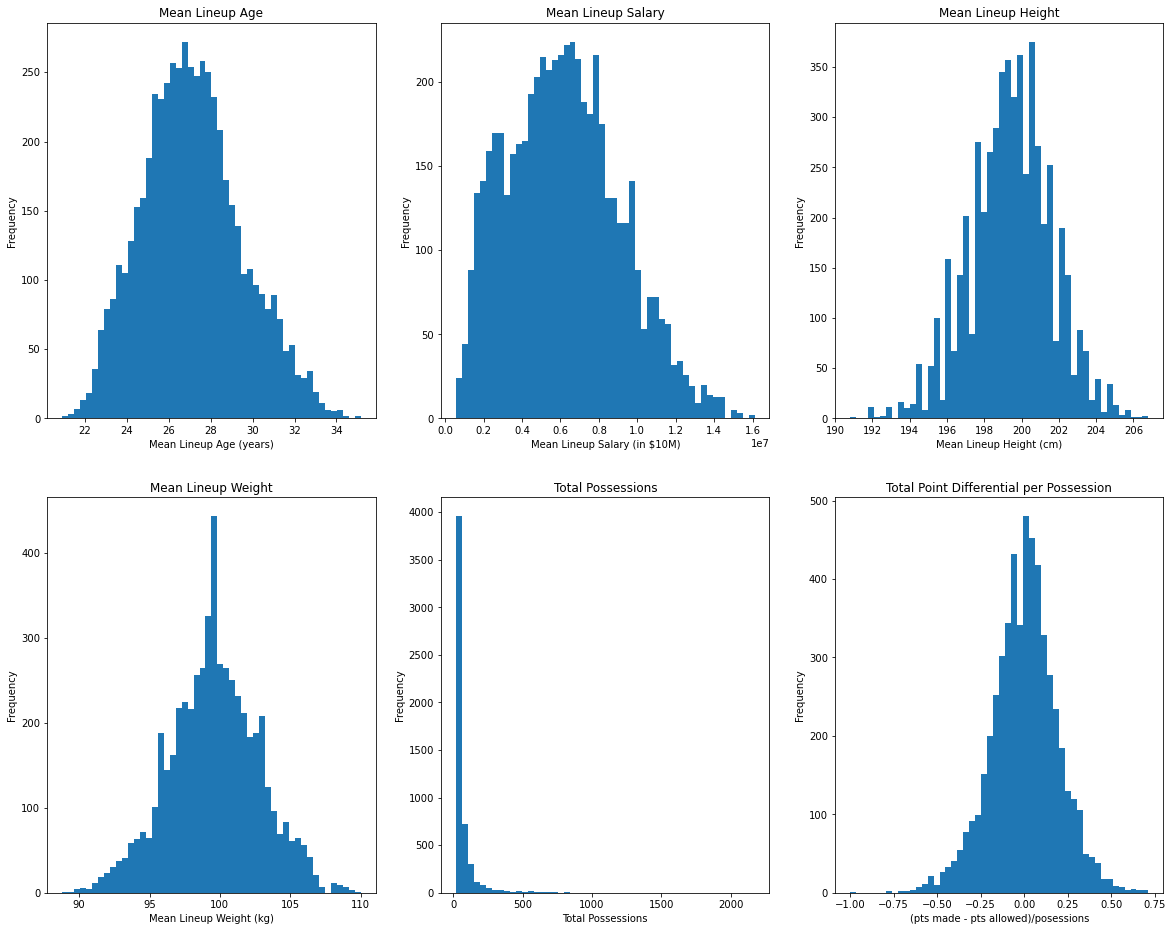

In [8]:
## Visualize Distributions ##

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

axes[0, 0].hist(df_2016_lineups_featues_mean['LineupMean_age'], bins=50)
axes[0, 0].set_xlabel("Mean Lineup Age (years)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Mean Lineup Age")

axes[0, 1].hist(df_2016_lineups_featues_mean['LineupMean_salary'], bins=50)
axes[0, 1].set_xlabel("Mean Lineup Salary (in $10M)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Mean Lineup Salary")

axes[0, 2].hist(df_2016_lineups_featues_mean['LineupMean_cm'], bins=50)
axes[0, 2].set_xlabel("Mean Lineup Height (cm)")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_title("Mean Lineup Height")

axes[1, 0].hist(df_2016_lineups_featues_mean['LineupMean_kg'], bins=50)
axes[1, 0].set_xlabel("Mean Lineup Weight (kg)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Mean Lineup Weight")

axes[1, 1].hist(df_2016_lineups_featues_mean['TotalPossessions'], bins=50)
axes[1, 1].set_xlabel("Total Possessions")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Total Possessions")

axes[1, 2].hist(df_2016_lineups_featues_mean['PtsDiff_perPos'], bins=50)
axes[1, 2].set_xlabel("(pts made - pts allowed)/posessions")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].set_title("Total Point Differential per Possession")
plt.show()


# NOTES
# The distributions for mean age, salary, height, and weight are not surprising. For each, looking at the upper and lower bounds
# of the figures can give you a good idea of what it takes to be an NBA play in 2016. E.g. the shortest person in the NBA at that time 
# was 195cm (6foot 3 inches), and the tallest person was 210cm (6 foot 9 inches), talk about genetic outliers..
# Total possession per lineup is also expected to be shaped this way. I had assumed that there would be some very uncommon lineups that would
# present itself in our analysis. Even if a player is put on the court for a few minutes, that counts as a unique combination, and thus
# is added to our dataset.
#
# Finally the performance metric that we will be using to asses the quality of a lineup is the amount of points scored, minus the amount
# of points allowed. For this figure I plotted the normalized version (normalized against # possessions), but two distributions look very similar.

                 Generalized Linear Model Regression Results                  
Dep. Variable:         PtsDiff_perPos   No. Observations:                 5440
Model:                            GLM   Df Residuals:                     5434
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                        0.036300
Method:                          IRLS   Log-Likelihood:                 1303.3
Date:                Thu, 09 Mar 2023   Deviance:                       197.25
Time:                        16:01:06   Pearson chi2:                     197.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0392      0.24

/var/folders/8c/kzx234q16zdf6dwkcnk692x80000gn/T/ipykernel_40080/3109210801.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Home'] = x['Home'].astype(int)
/Users/brianmiller/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


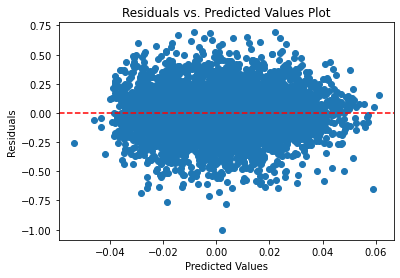

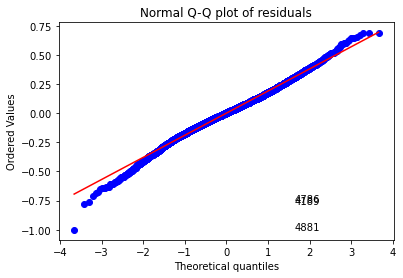

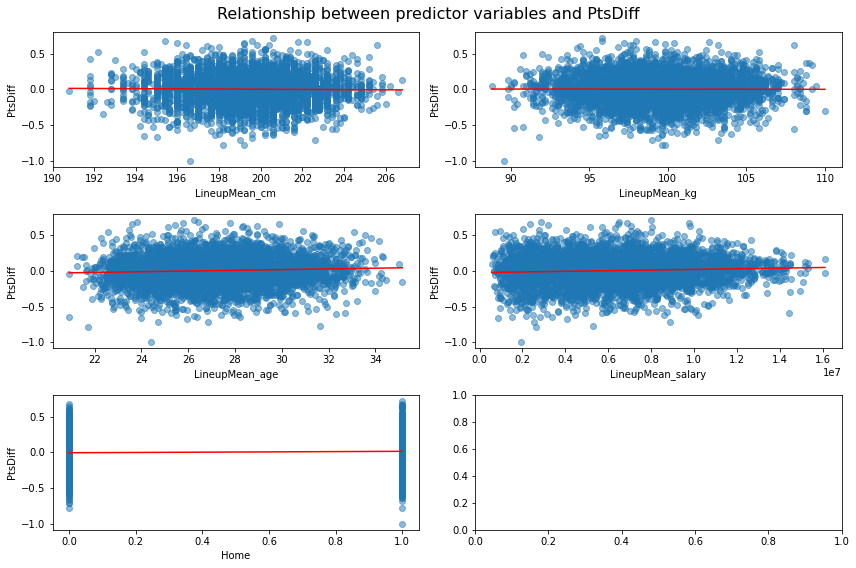

In [9]:
## LINEAR MODELING ##

# define the response variable (y) and predictor variables (x)
y= df_2016_lineups_featues_mean['PtsDiff_perPos']

x = df_2016_lineups_featues_mean[['LineupMean_cm', 'LineupMean_kg', 'LineupMean_age', 'LineupMean_salary','Home']]
x['Home'] = x['Home'].astype(int)

# Fit a generalized linear model using statsmodels
X = sm.add_constant(x)
model = sm.GLM(y, X, family=sm.families.Gaussian())
results = model.fit()

# print a summary of the results
print(results.summary())

## plot residuals against predicted values
# this is to check the assumption of equal variances among the predictor variables
y_pred = results.predict(X)
residuals = y - y_pred

fig, ax = plt.subplots()
ax.scatter(y_pred, residuals)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs. Predicted Values Plot')
plt.show()


## create a Q-Q plot of the residuals
stats.probplot(residuals, dist="norm", plot=plt)
# add data point labels to the plot
abs_norm_residuals = np.flipud(np.argsort(np.abs(residuals)))
abs_norm_residuals_top = abs_norm_residuals[:3]
for i in abs_norm_residuals_top:
    plt.text(stats.norm.ppf(0.95, loc=0, scale=1),
             residuals[i],
             df_2016_lineups_featues_mean.index[i])
plt.title("Normal Q-Q plot of residuals")
plt.show()


## set up the plot to assess correlations
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
ax = ax.flatten()

# loop over each predictor variable and plot the relationship with y
for i, col in enumerate(x.columns):
    # scatter plot of the variable against the response variable
    ax[i].scatter(x[col], y, alpha=0.5)
    
    # add a red trendline
    xfit = np.linspace(x[col].min(), x[col].max(), num=100)
    yfit = np.polyval(np.polyfit(x[col], y, 1), xfit)
    ax[i].plot(xfit, yfit, color='red')
    
    # set the xlabel and ylabel of each subplot
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('PtsDiff')
    
# set the title of the plot
fig.suptitle('Relationship between predictor variables and PtsDiff', fontsize=16)

# adjust the spacing between subplots
fig.tight_layout()

# NOTES
# In order to analyze which variables are most important for predicting the performance of a given lineup, we decided to run a linear model.
# Specifically, we decided on using a generalized linear model, as it allows for multiple different distribution types for your explanatory
# variables. From the results we can see that salary, age, and Home were significantly associated with performance. This makes
# sense, the more money, experience, and home games you have, the better your team and thus lineups are expected to perform.
#
# When performing a GLM there are some assumptions that need to be checked:
# 1. Normality (check with QQ plot)
# 2. Homoscedasticity (check with residuals plot)
# 3. Linearity (check with scatterplots). Ours looks fine, there are no large enough coefficients to visually stick out. But given
# the number of data points a subtle slope might not be easily visible to hte human eye

In [10]:
## Visualize individual player contributions to lineups ##

# for all of 2016, get all of the unique 5-player lineups from either team
df_lineups_playerStats = get_lineup_results(df_2016, return_lineup_matchups=False)

# define all of the different stats and performance metrics that nba-reference.com tracks
table_cols = [('info',('Height_cm', 'Mass_kg', 'age', 'salary')),
              ('advanced',('USG%','OBPM','DBPM','VORP')),
              ('per_poss',('PTS','ORtg', 'DRtg')),
             ]

# for each of the stats and performance metrics, go get them from nba-reference.com for each play on each 5-player lineup
# the agg='list' param returns 5 columns for each col, one column per player in the lineup, ordered 1-5 by the player height
for t, cols in table_cols:
    for col in cols:
        df_lineups_playerStats = get_lineup_feature(df_lineups_playerStats, 
                                   table_name=t,
                                   col_name=col,
                                   seasons_ago=0,
                                   agg='list',
                                   delta_AwayHome=False)

# as before, just look at 5-player lineups with more than 20 posessions
df_lineups_playerStats = df_lineups_playerStats[df_lineups_playerStats['TotalPossessions'] > 20].copy()

print(df_lineups_playerStats.columns.to_list())
df_lineups_playerStats.head()

['Season', 'Lineup', 'SecElapsed', 'Home', 'OffPoss', 'DefPoss', 'PtsScored', 'PtsAllowed', 'OffPPP', 'DefPPP', 'TotalPossessions', 'SecElapsedCumDist', 'TotPossCumDist', 'Lineup1_cm', 'Lineup2_cm', 'Lineup3_cm', 'Lineup4_cm', 'Lineup5_cm', 'Lineup1_kg', 'Lineup2_kg', 'Lineup3_kg', 'Lineup4_kg', 'Lineup5_kg', 'Lineup1_age', 'Lineup2_age', 'Lineup3_age', 'Lineup4_age', 'Lineup5_age', 'Lineup1_salary', 'Lineup2_salary', 'Lineup3_salary', 'Lineup4_salary', 'Lineup5_salary', 'Lineup1_USG%', 'Lineup2_USG%', 'Lineup3_USG%', 'Lineup4_USG%', 'Lineup5_USG%', 'Lineup1_OBPM', 'Lineup2_OBPM', 'Lineup3_OBPM', 'Lineup4_OBPM', 'Lineup5_OBPM', 'Lineup1_DBPM', 'Lineup2_DBPM', 'Lineup3_DBPM', 'Lineup4_DBPM', 'Lineup5_DBPM', 'Lineup1_VORP', 'Lineup2_VORP', 'Lineup3_VORP', 'Lineup4_VORP', 'Lineup5_VORP', 'Lineup1_PTS', 'Lineup2_PTS', 'Lineup3_PTS', 'Lineup4_PTS', 'Lineup5_PTS', 'Lineup1_ORtg', 'Lineup2_ORtg', 'Lineup3_ORtg', 'Lineup4_ORtg', 'Lineup5_ORtg', 'Lineup1_DRtg', 'Lineup2_DRtg', 'Lineup3_DRtg', '

,Season,Lineup,SecElapsed,Home,OffPoss,DefPoss,PtsScored,PtsAllowed,OffPPP,DefPPP,...,Lineup1_ORtg,Lineup2_ORtg,Lineup3_ORtg,Lineup4_ORtg,Lineup5_ORtg,Lineup1_DRtg,Lineup2_DRtg,Lineup3_DRtg,Lineup4_DRtg,Lineup5_DRtg
0,2015-16,"teaguje01,bazemke01,korveky01,millspa01,horfoal01",32029.0,False,1088,1085,1154,1137,1.060662,1.047926,...,105.0,99.0,104.0,108.0,113.0,104.0,100.0,105.0,96.0,101.0
1,2015-16,"westbru01,roberan03,ibakase01,duranke01,adamsst01",33182.0,True,1079,1082,1276,1052,1.182576,0.972274,...,115.0,119.0,108.0,122.0,123.0,103.0,106.0,105.0,104.0,105.0
2,2015-16,"westbru01,roberan03,ibakase01,duranke01,adamsst01",32342.0,False,1046,1050,1185,1092,1.132887,1.040000,...,115.0,119.0,108.0,122.0,123.0,103.0,106.0,105.0,104.0,105.0
3,2015-16,"teaguje01,bazemke01,korveky01,millspa01,horfoal01",28959.0,True,983,966,1032,951,1.049847,0.984472,...,105.0,99.0,104.0,108.0,113.0,104.0,100.0,105.0,96.0,101.0
4,2015-16,"jacksre01,caldwke01,morrima03,ilyaser01,drumman01",27889.0,False,902,890,930,937,1.031042,1.052809,...,109.0,107.0,107.0,109.0,103.0,108.0,107.0,108.0,106.0,98.0


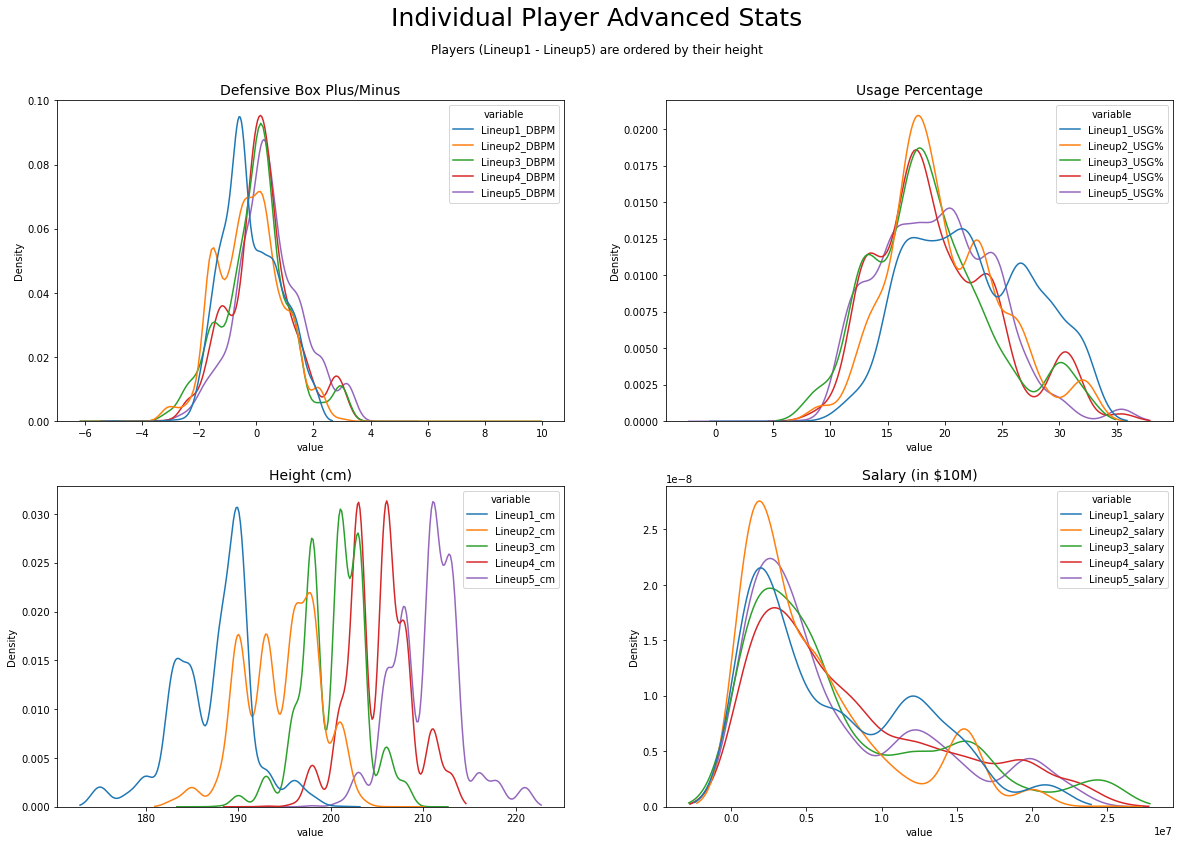

In [11]:
# I have chosen four NBA statistics that I think are useful to demonstrate the differences and trends between
# the five players on a given lineup

# melt the dfs into a format that sns can use for visualizations
den_df_dbpm = melt_df(df_lineups_playerStats, id_cols=['Season', 'Lineup', 'Home','TotalPossessions'], col_substr='DBPM')
den_df_usg = melt_df(df_lineups_playerStats, id_cols=['Season', 'Lineup', 'Home','TotalPossessions'], col_substr='USG%')
den_df_cm = melt_df(df_lineups_playerStats, id_cols=['Season', 'Lineup', 'Home','TotalPossessions'], col_substr='_cm')
den_df_salary = melt_df(df_lineups_playerStats, id_cols=['Season', 'Lineup', 'Home','TotalPossessions'], col_substr='_salary')

# Create a 2 by 2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 13))

# make the density plots
sns.kdeplot(data=den_df_dbpm, x='value', hue='variable', weights='TotalPossessions', bw_adjust=1, ax=axes[0, 0])
axes[0, 0].set_title('Defensive Box Plus/Minus', fontsize=14)
sns.kdeplot(data=den_df_usg, x='value', hue='variable', weights='TotalPossessions', bw_adjust=1, ax=axes[0, 1])
axes[0, 1].set_title('Usage Percentage', fontsize=14)
sns.kdeplot(data=den_df_cm, x='value', hue='variable', weights='TotalPossessions', bw_adjust=1, ax=axes[1, 0])
axes[1, 0].set_title('Height (cm)', fontsize=14)
sns.kdeplot(data=den_df_salary, x='value', hue='variable', weights='TotalPossessions', bw_adjust=1, ax=axes[1, 1])
axes[1, 1].set_title('Salary (in $10M)', fontsize=14)

# Set the title for the whole figure, and a subtitle
fig.suptitle("Individual Player Advanced Stats", fontsize=25)
fig.text(0.5, 0.93, "Players (Lineup1 - Lineup5) are ordered by their height", ha='center', fontsize=12)

# Display the figure
plt.show()

# DBPM (Defensive Box Plus/Minus)
# Measures the difference per 100 possessions in points allowed with a player on the court versus off the court

# USG% (Usage Percentage)
# An estimate of the percentage of team plays used by a player while they were on the floor